# Analyzing NYC High School Data

This is a continuation of work we performed in the course, where we took information from seven different data files, cleaned and combined those files, and created a single file with which we can perform analysis.

## Read in the data

In [1]:
# bring in all of the csv files

import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
# bring in the two text files (tab delimited)
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
# the DBN column will be our key
# we need to add it where it doesn't yet exist
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
# sum up the SAT components to get a total score
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# pull out the latitude and longitude data
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
# filter down the datasets to only those rows that match with our SAT data
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
# convert these columns to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
# merge the datasets
combined = data["sat_results"]

# use left join where the additional datasets are missing values
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# use inner join where we only want these in our final dataset if this info
# is available
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
# pull out district from the  DBN field
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
# find correlations and filter to the column for SAT scores
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting survey correlations

In [10]:
# remove DBN since it's not useful for correlation
survey_fields.remove("DBN")

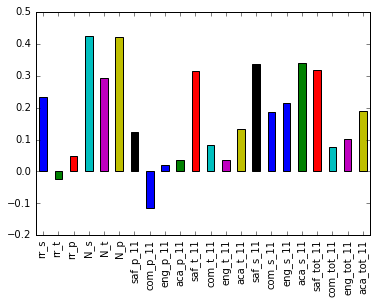

In [11]:
# create bar plot of correlations for those columns from survey_fields
combined.corr()['sat_score'][survey_fields].plot.bar()

From the above bar graph, it appeas that the highest correlated variables are `N_s` and `N_p`, which are the number of student respondents and number of parent respondents, respectively, to the survey.  This could be because those students where the student or the parent is involved enough to respond to the survey may be more involved in the student's academic performance.

The next group of correlated variables includes `aca_s_11`, `saf_tot_11`, `saf_s_11`, and `saf_t_11`, which are academic expectations score based on student responses, safety and respect total score, safety and respect score based on student responses, and safety and respect score based on teacher responses.

This seems to indicate a correlation between both a student's own academic expectations and SAT score, as well as a correlation between safety and respect and SAT score.  While it makes sense that those who have higher academic expectations of themselves would tend to do better on the SAT, it is not immediately clear why higher safety and respect scores are correlated with higher SAT scores.

Do higher safety and respect scores mean that students and teachers can spend more time on academics and less time on dealing with saefty and respect issues?  Is more of the school day focused on academics?  Are there less suspensions and explusions, meaning students are in class more?  Do higher safety and respect scores mean that these students are more likely to do as their parents and teachers ask, maybe such things as going to school every day, completing homework, not getting involved with drugs and alcohol, etc.?

Let's investigate this relationship further.

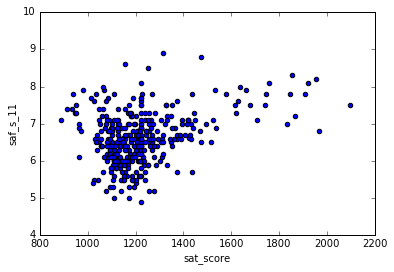

In [12]:
# investigate safety scores further in a scatter plot
combined.plot.scatter('sat_score', 'saf_s_11')
plt.show()

While there is a correlation between SAT scores and safety and respect scores as reported by the students, the correlation is not very strong. We can see that those with very high SAT scores have higher safety and respect scores. There is also a grouping with both low SAT scores and low safety and respect scores.

However, just having a high safety and respect score does not mean that the SAT score is necessarily higher. For example, there is a grouping with safety and respect scores above 7 that still have SAT scores below 1200.

In [13]:
# create districts
districts = combined.groupby(['school_dist']).agg(numpy.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


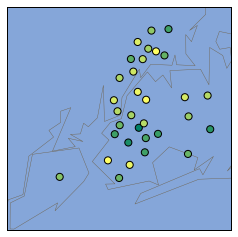

In [14]:
# create a map of safety scores by district
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, 
              c=districts['saf_s_11'], cmap='summer')
plt.show()

It appears that Brooklyn has lower safety and respect scores, while the scores are on average higher in Manhattan, the Bronx, and Queens.

## SAT Scores and Race

Next we will look at the racial differences in SAT scores using a variety of tools.

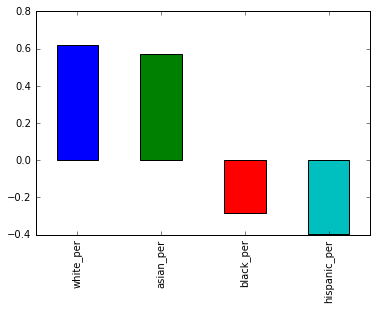

In [15]:
# make a bar graph of correlations between race variables and SAT scores
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][races].plot.bar()

From the above, it appears that having higher percentages of whites or asians is correlated with higher SAT scores, while having higher percentages or blacks or hispanics is correlated with lower SAT scores.

As the correlation with hispanic percentage is the most negative, let's look further at this relationship.

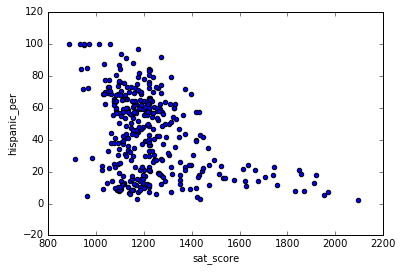

In [16]:
# scatter plot of SAT scores and hispanic percentage
combined.plot.scatter('sat_score', 'hispanic_per')
plt.show()

From the above scatter plot, it appears that those schools with higher SAT scores (above 1500) all have hispanic percentages that are below 25%.  For lower SAT scores, the hispanic percentage varies from near zero to 100%.

In [17]:
# look more closely at schools with very high hispanic percentage
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Based on some Google searches of the above schools, it appears that these schools cater to immigrants and students who primarily speak Spanish rather than English.  As they are still learning to speak English, that may explain why the SAT scores are lower (as this test is given only in English).

In [18]:
# look more closely at schools with very low hispanic percentage
# and high SAT scores
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Based on some Google searches of the above schools, these schools appear to be elite schools that cater to students who are high-achievers academically.  It does not explain why they have low Hispanic percentages but does explain why the SAT scores are so high for these schools.

## SAT Scores and Gender

Now let's look more closely at the relationship between SAT scores and gender.

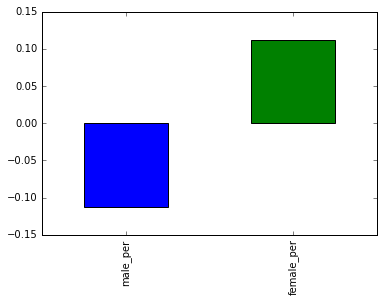

In [19]:
# make a bar graph of correlations between gender variables and SAT scores
genders = ['male_per', 'female_per']
combined.corr()['sat_score'][genders].plot.bar()

While the correlations shown above are quite weak, there is a small positive correlation between SAT scores and the percentage of students who are female, while there is a small negative correlation between SAT scores and the percentage of students who are male.

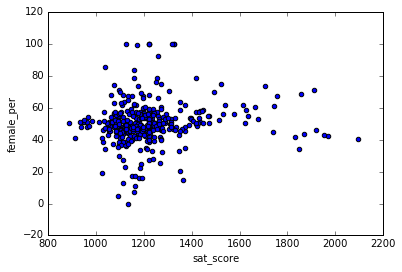

In [20]:
# scatter plot of SAT scores and female percentage
combined.plot.scatter('sat_score', 'female_per')
plt.show()

There is not much correlation shown in the above scatter plot, though there is a group of schools with higher SAT scores and percentages of females above 60%.

In [21]:
# look more closely at schools with high female percentage
# and high SAT scores
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be selective, college prep high schools, which would explain the higher SAT scores (but not the higher percentages of females).

## SAT Scores and AP Exams

Next let's look at the correlation between AP Exams (exams that may be taken in high school for college credit) and SAT scores.  We would expect that schools where more AP Exams are taken (or passed) would be correlated with higher SAT scores.

In [22]:
# determine the percentage of students who took AP exams
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

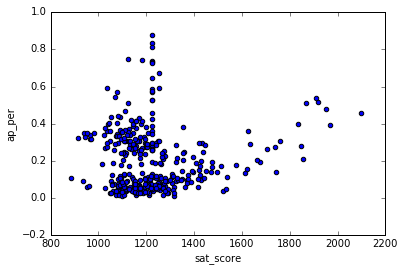

In [23]:
# scatter plot of SAT scores and AP exams percentage
combined.plot.scatter('sat_score', 'ap_per')
plt.show()

While the relationship is not strong, there is some positive correlation between AP exams and SAT scores.  This seems to be a stronger relationship for higher SAT scores (those above 1500) than for lower SAT scores (those below 1500).

Does this relationship look any different if we instead focus on those who passed the AP Exam (a score of 3, 4, or 5) rather than overall number of test takers?

In [24]:
# determine the percentage of students who passed AP exams
combined['ap_pass_per'] = combined['Number of Exams with scores 3 4 or 5'] / combined['total_enrollment']
combined['ap_pass_per'].head()

0    0.363626
1    0.025381
2    0.256605
3    0.418120
4    0.118413
Name: ap_pass_per, dtype: float64

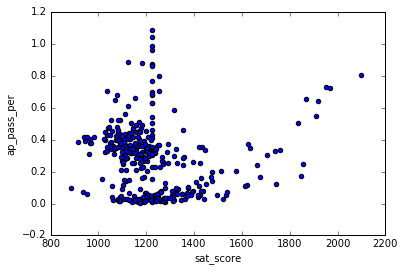

In [25]:
# scatter plot of SAT scores and AP exams passed percentage
combined.plot.scatter('sat_score', 'ap_pass_per')
plt.show()

We still see the same general pattern, in that SAT scores above 1500, the relationship is clearly positive, and stronger in this case.  However, below 1500, there is not a clear relationship.

## SAT Scores and Class Size

Does class size have any correlation with SAT scores?  Let's investigate below.

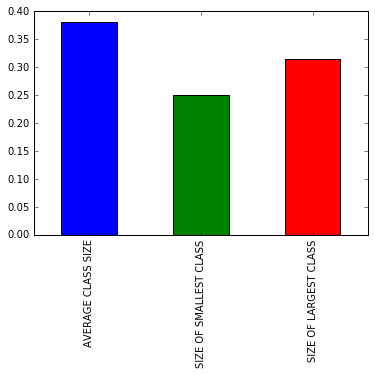

In [26]:
# make a bar graph of correlations between class size variables and SAT scores
classes = ['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']
combined.corr()['sat_score'][classes].plot.bar()

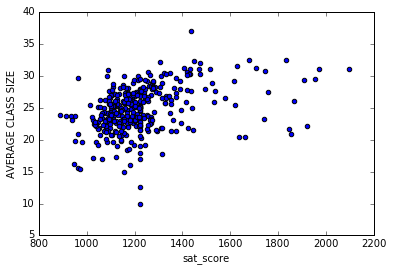

In [27]:
# scatter plot of SAT scores and average class size
combined.plot.scatter('sat_score', 'AVERAGE CLASS SIZE')
plt.show()

There is a positive relationship between SAT scores and class size, which at first seems surprising.  One might think that smaller classes, with more individualized attention to students, would produce higher SAT scores.  However, what we see is that the smaller average class sizes, those less than 20, have lower SAT scores, while the higher SAT scores tend to have average class sizes between 20 and about 33.

This relationship may be explained by those with small class sizes are more focused on something else, such as teaching English as a second language.  Let's look at the group of schools with low SAT scores and low class size.

In [28]:
# look more closely at schools with low average class size
# and low SAT scores
combined[(combined['AVERAGE CLASS SIZE'] < 18) & (combined['sat_score'] < 1200)]['SCHOOL NAME']

6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
8                                   ESSEX STREET ACADEMY
91                   INTERNATIONAL COMMUNITY HIGH SCHOOL
126                      BRONX INTERNATIONAL HIGH SCHOOL
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
208                              FRANCES PERKINS ACADEMY
265               INTERNATIONAL HIGH SCHOOL AT LAFAYETTE
291    INTERNATIONAL HIGH SCHOOL AT LAGUARDIA COMMUNI...
Name: SCHOOL NAME, dtype: object

From some Google searches, it appears that these schools are focused on teaching other subjects as well, such as sign language, getting shy children to come out of their shell, and teaching English as a second language.  This may account for the small class sizes.